# Coverage of MultiPLIER LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The PLIER model performs a matrix factorization of gene expression data to get two matrices: loadings (Z) and latent matrix (B). The loadings (Z) are constrained to aligned with curated pathways and gene sets specified by prior knowledge [Figure 1B of Taroni et. al.](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(19)30119-X). This ensure that some but not all latent variables capture known biology. The way PLIER does this is by applying a penalty such that the individual latent variables represent a few gene sets in order to make the latent variables more interpretable. Ideally there would be one latent variable associated with one gene set unambiguously.

While the PLIER model was trained on specific datasets, MultiPLIER extended this approach to all of recount2, where the latent variables should correspond to specific pathways or gene sets of interest. Therefore, we will look at the coverage of generic genes versus other genes across these MultiPLIER latent variables, which represent biological patterns.

**Definitions:**
* Generic genes: Are genes that are consistently differentially expressed across multiple simulated experiments.

* Other genes: These are all other non-generic genes. These genes include those that are not consistently differentially expressed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged (i.e. housekeeping genes)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import textwrap
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import lv

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "human_general_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

project_id = params["project_id"]
quantile_threshold = 0.98

In [3]:
# Output file
nonzero_figure_filename = "nonzero_LV_coverage.svg"
highweight_figure_filename = "highweight_LV_coverage.svg"

## Load data

In [4]:
# Get gene summary file
summary_data_filename = os.path.join(data_dir, f"generic_gene_summary_{project_id}.tsv")

In [5]:
# Load gene summary data
data = pd.read_csv(summary_data_filename, sep="\t", index_col=0, header=0)

# Check that genes are unique since we will be using them as dictionary keys below
assert data.shape[0] == len(data["Gene ID"].unique())

In [6]:
# Load multiplier models
# Converted formatted pickle files (loaded using phenoplier environment) from
# https://github.com/greenelab/phenoplier/blob/master/nbs/01_preprocessing/005-multiplier_recount2_models.ipynb
# into .tsv files
multiplier_model_z = pd.read_csv(
    "multiplier_model_z.tsv", sep="\t", index_col=0, header=0
)

In [7]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value != 0 for a given LV)
# Notice that multiPLIER is a sparse model
(multiplier_model_z != 0).sum().sort_values(ascending=True)

LV37      174
LV935     282
LV912     299
LV45      401
LV817     414
LV921     498
LV61      680
LV819    1065
LV556    1159
LV13     1426
LV730    1446
LV36     1459
LV249    1510
LV847    1522
LV540    1534
LV12     1563
LV14     1603
LV29     1632
LV5      1668
LV759    1728
LV118    1735
LV536    1793
LV59     1797
LV245    1812
LV42     1831
LV11     1832
LV234    1843
LV765    1852
LV252    1857
LV149    1864
         ... 
LV687    3709
LV282    3715
LV9      3717
LV966    3725
LV367    3732
LV636    3734
LV476    3739
LV940    3747
LV526    3754
LV478    3754
LV974    3761
LV732    3779
LV55     3806
LV835    3910
LV379    3953
LV625    3993
LV607    4015
LV74     4025
LV229    4094
LV976    4128
LV395    4220
LV70     4280
LV987    4285
LV739    4441
LV889    4471
LV841    4504
LV516    4520
LV984    4605
LV915    4640
LV830    5496
Length: 987, dtype: int64

## Get gene data

Define generic genes based on simulated gene ranking. Refer to [figure](https://github.com/greenelab/generic-expression-patterns/blob/master/human_general_analysis/gene_ranking_log2FoldChange.svg) as a guide.

**Definitions:**
* Generic genes: `Percentile (simulated) >= 60`

(Having a high rank indicates that these genes are consistently changed across simulated experiments.)

* Other genes: `Percentile (simulated) < 60`

(Having a lower rank indicates that these genes are not consistently changed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged.)

In [8]:
generic_threshold = 60
dict_genes = lv.get_generic_specific_genes(data, generic_threshold)

(17755, 13)
No. of generic genes: 7102
No. of other genes: 10653


In [9]:
# Check overlap between multiplier genes and our genes
multiplier_genes = list(multiplier_model_z.index)
our_genes = list(data.index)
shared_genes = set(our_genes).intersection(multiplier_genes)

print(len(our_genes))
print(len(shared_genes))

17755
6374


In [10]:
# Drop gene ids not used in multiplier analysis
processed_dict_genes = lv.process_generic_specific_gene_lists(
    dict_genes, multiplier_model_z
)

In [11]:
# Check numbers add up
assert len(shared_genes) == len(processed_dict_genes["generic"]) + len(
    processed_dict_genes["other"]
)

## Get coverage of LVs

For each gene (generic or other) we want to find:
1. The number of LVs that gene is present
2. The number of LVs that the gene contributes a lot to (i.e. the gene is highly weighted within that LV)

### Nonzero LV coverage

In [12]:
dict_nonzero_coverage = lv.get_nonzero_LV_coverage(
    processed_dict_genes, multiplier_model_z
)

In [13]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_nonzero_coverage["generic"].index
assert len(dict_nonzero_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_nonzero_coverage["other"]) == len(processed_dict_genes["other"])

### High weight LV coverage

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


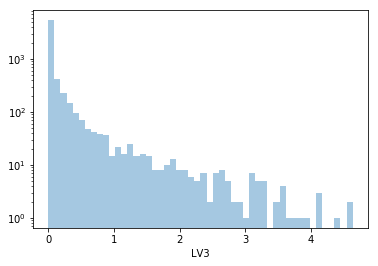

In [14]:
# Quick look at the distribution of gene weights per LV
sns.distplot(multiplier_model_z["LV3"], kde=False)
plt.yscale("log")

In [15]:
dict_highweight_coverage = lv.get_highweight_LV_coverage(
    processed_dict_genes, multiplier_model_z, quantile_threshold
)

In [16]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_highweight_coverage["generic"].index
assert len(dict_highweight_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_highweight_coverage["other"]) == len(processed_dict_genes["other"])

### Assemble LV coverage and plot

In [17]:
all_coverage = []
for gene_label in dict_genes.keys():
    merged_df = pd.DataFrame(
        dict_nonzero_coverage[gene_label], columns=["nonzero LV coverage"]
    ).merge(
        pd.DataFrame(
            dict_highweight_coverage[gene_label], columns=["highweight LV coverage"]
        ),
        left_index=True,
        right_index=True,
    )
    merged_df["gene type"] = gene_label
    all_coverage.append(merged_df)

all_coverage_df = pd.concat(all_coverage)

In [18]:
all_coverage_df = lv.assemble_coverage_df(
    processed_dict_genes, dict_nonzero_coverage, dict_highweight_coverage
)
all_coverage_df.head()

,nonzero LV coverage,highweight LV coverage,gene type
MMP25,435,4,generic
TYROBP,368,11,generic
CAMKK1,450,8,generic
PROZ,405,9,generic
CDCP1,367,22,generic


Text(0.5, 1.0, 'Number of LVs genes are present in')

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


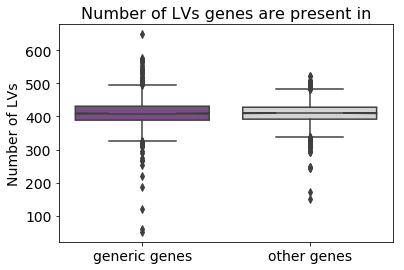

In [19]:
# Plot coverage distribution given list of generic coverage, specific coverage
nonzero_fig = sns.boxplot(
    data=all_coverage_df,
    x="gene type",
    y="nonzero LV coverage",
    notch=True,
    palette=["#81448e", "lightgrey"],
)
nonzero_fig.set_xlabel(None)
nonzero_fig.set_xticklabels(
    ["generic genes", "other genes"], fontsize=14, fontname="Verdana"
)
nonzero_fig.set_ylabel(
    textwrap.fill("Number of LVs", width=30), fontsize=14, fontname="Verdana"
)
nonzero_fig.tick_params(labelsize=14)
nonzero_fig.set_title(
    "Number of LVs genes are present in", fontsize=16, fontname="Verdana"
)

Text(0.5, 1.0, 'Number of LVs genes contribute highly to')

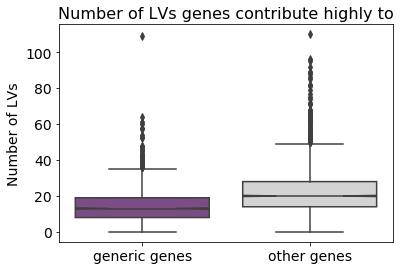

In [20]:
# Plot coverage distribution given list of generic coverage, specific coverage
highweight_fig = sns.boxplot(
    data=all_coverage_df,
    x="gene type",
    y="highweight LV coverage",
    notch=True,
    palette=["#81448e", "lightgrey"],
)
highweight_fig.set_xlabel(None)
highweight_fig.set_xticklabels(
    ["generic genes", "other genes"], fontsize=14, fontname="Verdana"
)
highweight_fig.set_ylabel(
    textwrap.fill("Number of LVs", width=30), fontsize=14, fontname="Verdana"
)
highweight_fig.tick_params(labelsize=14)
highweight_fig.set_title(
    "Number of LVs genes contribute highly to", fontsize=16, fontname="Verdana"
)

## Calculate statistics
* Is the reduction in generic coverage significant?
* Is the difference between generic versus other genes signficant?

In [21]:
# Test: mean number of LVs generic genes present in vs mean number of LVs that generic gene is high weight in
# (compare two blue boxes between plots)
generic_nonzero = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "nonzero LV coverage"
].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "highweight LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(generic_nonzero, generic_highweight)
print(pvalue)

0.0


In [22]:
# Test: mean number of LVs generic genes present in vs mean number of LVs other genes high weight in
# (compare blue and grey boxes in high weight plot)
other_highweight = all_coverage_df[all_coverage_df["gene type"] == "other"][
    "highweight LV coverage"
].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "highweight LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(other_highweight, generic_highweight)
print(pvalue)

6.307987998525766e-119


In [23]:
# Check that coverage of other and generic genes across all LVs is NOT signficantly different
# (compare blue and grey boxes in nonzero weight plot)
other_nonzero = all_coverage_df[all_coverage_df["gene type"] == "other"][
    "nonzero LV coverage"
].values
generic_nonzero = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "nonzero LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(other_nonzero, generic_nonzero)
print(pvalue)

0.23947472582519233


## Get LVs that generic genes are highly weighted in

Since we are using quantiles to get high weight genes per LV, each LV has the same number of high weight genes. For each set of high weight genes, we will get the proportion of generic vs other genes. We will select the LVs that have a high proportion of generic genes to examine.

In [24]:
# Get proportion of generic genes per LV
prop_highweight_generic_dict = lv.get_prop_highweight_generic_genes(
    processed_dict_genes, multiplier_model_z, quantile_threshold
)

In [25]:
# Return selected rows from summary matrix
multiplier_model_summary = pd.read_csv(
    "multiplier_model_summary.tsv", sep="\t", index_col=0, header=0
)
lv.create_LV_df(
    prop_highweight_generic_dict,
    multiplier_model_summary,
    0.5,
    "Generic_LV_summary_table.tsv",
)

LV2 0.5185185185185185
LV3 0.6444444444444445
LV7 0.562962962962963
LV11 0.5851851851851851
LV17 0.5703703703703704
LV18 0.5333333333333333
LV22 0.5185185185185185
LV26 0.5111111111111111
LV32 0.5481481481481482
LV34 0.5333333333333333
LV54 0.562962962962963
LV57 0.5259259259259259
LV58 0.5703703703703704
LV61 0.6222222222222222
LV68 0.6296296296296297
LV101 0.5481481481481482
LV135 0.5185185185185185
LV473 0.5481481481481482
LV524 0.6074074074074074
LV542 0.5259259259259259
LV603 0.5185185185185185
LV719 0.6074074074074074
LV728 0.6074074074074074
LV765 0.6370370370370371
LV767 0.5333333333333333
LV787 0.5037037037037037
LV823 0.6222222222222222
LV913 0.5777777777777777
LV920 0.6074074074074074
LV932 0.5185185185185185
LV958 0.5333333333333333
LV960 0.5333333333333333
LV977 0.5481481481481482


0     6.540359
1     6.527677
2     2.738563
3     1.470443
4     1.272303
5     0.982001
6     0.842076
7     0.715623
8     0.714085
9     0.615867
10    0.567222
11    0.535279
12    0.532891
13    0.525537
14    0.522841
15    0.483024
16    0.475159
17    0.469341
18    0.462943
19    0.439901
Name: LV61, dtype: float64


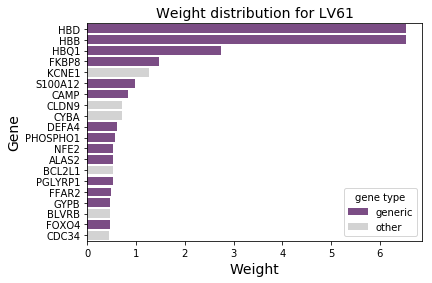

In [26]:
# Plot distribution of weights for these nodes
node = "LV61"
lv.plot_dist_weights(
    node,
    multiplier_model_z,
    shared_genes,
    20,
    all_coverage_df,
    f"weight_dist_{node}.svg",
)

## Save

In [27]:
# Save plot
nonzero_fig.figure.savefig(
    nonzero_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

# Save plot
highweight_fig.figure.savefig(
    highweight_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* In the first nonzero boxplot, generic and other genes are present in a similar number of LVs. This isn't surprising since the number of genes that contribute to each LV is <1000.
* In the second highweight boxplot, other genes are highly weighted in more LVs compared to generic genes. This would indicate that generic genes contribute alot to few LVs.

This is the opposite trend found using [_P. aeruginosa_ data](1_get_eADAGE_LV_coverage.ipynb). Perhaps this indicates that generic genes have different behavior/roles depending on the organism. In humans, perhaps these generic genes are related to a few hyper-responsive pathways, whereas in _P. aeruginosa_ perhaps generic genes are associated with many pathways, acting as *gene hubs*.

* There are a number of LVs that contain a high proportion of generic genes can be found in [table](Generic_LV_summary_table.tsv). By quick visual inspection, it looks like many LVs are associated with immune response, signaling and metabolism. Which are consistent with the hypothesis that these generic genes are related to hyper-responsive pathways.